# Visualize 3D object detection output
This notebook contains how to reproduce a notebook file like [here](https://github.com/Owen-Liuyuxuan/visualDet3D/blob/master/demos/visualize_test_3d_stereo.ipynb).

# Install Dependencies

In [ ]:
# Git Clone Repo
!git clone https://github.com/jingwoo4710/visualDet3D.git

Cloning into 'visualDet3D'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (203/203), done.
remote: Total 254 (delta 86), reused 217 (delta 49), pack-reused 0
Receiving objects: 100% (254/254), 24.25 MiB | 29.25 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [ ]:
%cd /content/visualDet3D/
!pip3 install -r requirement.txt

In [ ]:
# build ops (deform convs and iou3d), We will not install operations into the system environment
!./make.sh

/content/visualDet3D/visualDet3D/networks/lib/ops/dcn /content/visualDet3D
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:369: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
building '..deform_conv_ext' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/src
creating build/temp.linux-x86_64-3.7/src/cuda
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-security -I/usr/local/cuda/include -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -DWITH_CUDA -I/usr/local/lib/python3.7/dist-packages/torch/include -I/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include -I/usr/local/lib/python3.7/d

In [ ]:
!pip install coloredlogs

# Data Load

In [ ]:
# Create Dataset Folder 
%mkdir /content/visualDet3D/visualDet3D/data/kitti_obj

In [ ]:
# Google Drive Mount where raw datset is
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Download from Google Drive
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_calib.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_image_2.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_image_3.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj
!unzip -qq "/content/drive/MyDrive/project_2_dataset/data_object_label_2.zip" -d /content/visualDet3D/visualDet3D/data/kitti_obj

replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/calib/003206.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/image_2/002480.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/image_3/002970.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
replace /content/visualDet3D/visualDet3D/data/kitti_obj/training/label_2/003206.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


# Create Config File

In [ ]:
# Make config file
import os
%cd config

if not os.path.exists('/content/visualDet3D/config/kitti_mono.py'):
  # Copy Yolo3D_example to make .py file
  %cp Yolo3D_example kitti_mono.py

[Errno 2] No such file or directory: 'config'
/content/visualDet3D/config


In [ ]:
%ls

kitti_depth.py  KM3D_example       readme.md          Stereo3D_example
kitti_mono.py   MonoDepth_example  RetinaNet_example  Yolo3D_example


## 아래 셀 실행 전에 kitti_mono.py 파일의 24, 25, 26, 27 번째 라인 수정하기


path.data_path = "/content/visualDet3D/visualDet3D/data/kitti_obj/training"

path.test_path = "/content/visualDet3D/visualDet3D/data/kitti_obj/testing"

path.visualDet3D_path = "/content/visualDet3D/visualDet3D"

path.project_path = "/content/visualDet3D/workdirs"

# Import Libraries

In [ ]:
%cd ..
import sys
sys.path.append("/content/")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer
from numba import jit
from tqdm import tqdm
print('CUDA available: {}'.format(torch.cuda.is_available()))

# cfg = cfg_from_file("/content/visualDet3D/config/kitti_stereo.py")
cfg = cfg_from_file("/content/visualDet3D/config/kitti_mono.py")

is_test_train = True

#checkpoint_name = "Stereo3D_latest.pth" # Custom_dataset_training
checkpoint_name = "GroundAware_pretrained.pth" # pretrained_model

/content/visualDet3D
CUDA available: True


# Precomputation 

In [ ]:
%cd /content/visualDet3D/
## Compute image database and anchors mean/std
!./launchers/det_precompute.sh config/kitti_mono.py train
!./launchers/det_precompute.sh config/kitti_mono.py test

/content/visualDet3D
Precomputation for the training/validation split
start reading training data
training split finished precomputing
start reading validation data
validation split finished precomputing
Preprocessing finished
Precomputation for the test split
start reading test data
test split finished precomputing
Preprocessing finished


# Train

## 1. Custom Dataset Training

In [ ]:
## train the model with one GPU
!./launcher/train.sh  "/content/visualDet3D/config/kitti_mono.py" 0 train # validation goes along

## 2. Pre-trained Model

In [ ]:
# Precomputed data
%cp -r /content/drive/MyDrive/project_2_dataset/workdirs /content/visualDet3D/

In [ ]:
# Pre-trained Model
%cp /content/drive/MyDrive/project_2_dataset/GroundAware_pretrained.pth /content/visualDet3D/workdirs/Mono3D/checkpoint

In [ ]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn

# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to ./resnet101-5d3b4d8f.pth


# Visualize output

In [ ]:
# Define a function drawing 2D boxes
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [ ]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)


# Define a function denormalizing an image
def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

In [ ]:
# Define prediction function
def compute_once(index, is_draw=True, is_test_train=True):
    
    # Load image data
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    
    # Image original height
    original_height = data['original_shape'][0]

    # Collate data
    collated_data = dataset.collate_fn([data])

    # Image height
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    # if len(collated_data) > 6:
    #     left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    # else:
    #     left_images, right_images, _, _, labels, bbox_3d = collated_data
    # image = left_images

    # Split collated data
    left_images, _, labels, _, bbox_3d = collated_data
    image = left_images

    # Deactivates autograd engine
    with torch.no_grad():
        
        # Prediction
        left_images, P2 = collated_data[0], collated_data[1]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          P2.cuda().float()])
        
        # Prediction output
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    # Draw 2D, 3D boxes
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))

    return np.clip(rgb_image, 0, 255)
    

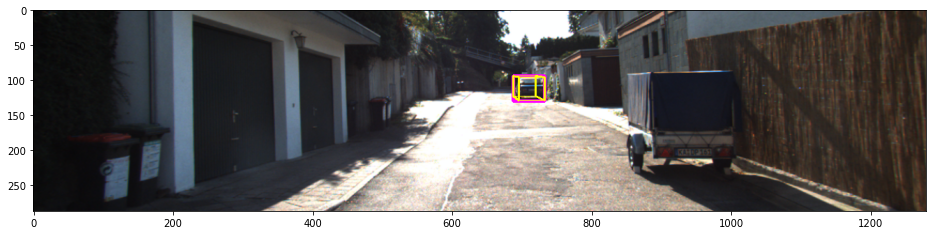

In [ ]:
# Sample 1
%matplotlib inline
fig = plt.figure(figsize=(16,9))
index += 1
a = compute_once(index, is_test_train=False, is_draw=True)

# Evaluation

In [ ]:
# Eval - result

!./launchers/eval.sh /content/visualDet3D/config/kitti_mono.py 0 /content/visualDet3D/workdirs/Mono3D/checkpoint/GroundAware_pretrained.pth validation

CUDA available: True
Found evaluate function
rebuild /content/visualDet3D/workdirs/Mono3D/output/validation/data
  0% 0/3769 [00:00<?, ?it/s]/content/visualDet3D/visualDet3D/networks/pipelines/testers.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [image.cuda().float().contiguous(), torch.tensor(P2).cuda().float()])
100% 3769/3769 [05:16<00:00, 11.93it/s]
/usr/local/lib/python3.7/dist-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "visualDet3D/evaluator/kitti/eval.py", line 129:
@numba.jit(nopython=True, parallel=True)
def d3_box_overlap_kernel(boxes,
^

  s

# Evaluation results comparison

||IOU $\geq$ 0.7 3D Easy/Moderate/Hard|IOU $\geq$ 0.5 3D Easy/Moderate/Hard|
|:--:|:--:|:--:|
|Paper|22.63% / 16.16% / 12.06%|60.92 %/ 42.18 %/ 32.02 %|
|Notebook|73.60% / 55.31% / 42.30%|93.50% /  80.96% / 61.66%|

From the evaluation part, we would like to compare the results as shown in the paper with the results of our notebook. The table  represents the results of the paper, and the notebook. It seems obvious that there are huge differences between them.

- Limitation <br>
The only way to obtain the results based on the test dataset is using KITTI leaderboard. Because only one entry per paper is submitted using as little trials as possible (ideally 1 or 2) to avoid overfitting, we were not able to submit our model. 

- Dataset <br>
Notebook evaluation resutls are based on the validation dataset, however paper results are based on the test dataset. Therefore, it's more likely to see the overfitting in the notebook results.